## Imports

In [65]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from flirpy.io.fff import Fff
from scipy.constants import c, h, k
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## Funtions

### Spectral Radiance

 The Planck function describes the radiation emitted by a black body at a given temperature. This is the physical basis for converting the radiation detected by the camera into temperatures.

In [6]:
def planck(wavelength, temperature):
    """
    Calculate spectral radiance using Planck's law.

    :param wavelength: Wavelength in meters
    :param temperature: Temperature in Kelvin
    :return: Spectral radiance in W⋅sr^−1⋅m^−3
    """
    return (2 * h * c**2) / (wavelength**5 * (np.exp((h * c) / (wavelength * k * temperature)) - 1))

### Radiometric Correction

This function converts raw sensor readings into actual temperatures, taking into account environmental factors and camera characteristics.

In [7]:
def apply_radiometric_corrections(raw_counts, metadata):
    """
    Apply full radiometric corrections to raw sensor counts.

    :param raw_counts: Raw sensor counts
    :param metadata: Dictionary containing camera and environmental metadata
    :return: Corrected temperature in Celsius
    """
    # Extraer metadata
    R1 = metadata['Planck R1']
    R2 = metadata['Planck R2']
    B = metadata['Planck B']
    F = metadata['Planck F']
    O = metadata['Planck O']
    emissivity = metadata['Emissivity']
    distance = metadata['Object Distance']
    atm_temp = metadata['Atmospheric Temperature'] + 273.15  # Convertir a Kelvin
    refl_temp = metadata['Reflected Apparent Temperature'] + 273.15  # Convertir a Kelvin
    humidity = metadata['Relative Humidity']

    # Cálculo de transmisión atmosférica
    X = metadata['Atmospheric Trans X']
    alpha1 = metadata['Atmospheric Trans Alpha 1']
    alpha2 = metadata['Atmospheric Trans Alpha 2']
    beta1 = metadata['Atmospheric Trans Beta 1']
    beta2 = metadata['Atmospheric Trans Beta 2']

    tau = X * np.exp(-np.sqrt(distance) * (alpha1 + beta1 * np.sqrt(humidity))) + \
          (1 - X) * np.exp(-np.sqrt(distance) * (alpha2 + beta2 * np.sqrt(humidity)))

    # Convertir raw a radiancia
    raw_refl = R1 / (R2 * (np.exp(B / refl_temp) - F)) - O
    raw_atm = R1 / (R2 * (np.exp(B / atm_temp) - F)) - O

    # Aplicar correcciones radiométricas
    raw_obj = (raw_counts - (1 - emissivity) * tau * raw_refl -
               (1 - tau) * raw_atm) / (emissivity * tau)

    # Convertir radiancia corregida a temperatura
    corrected_temp = B / np.log(R1 / (R2 * (raw_obj + O)) + F) - 273.15  # Convertir a Celsius

    return corrected_temp

### Segment Image

It implements a spatial analysis strategy by dividing the thermal images into a 3x3 grid, creating nine equal segments. This segmentation is essential for analysing spatial patterns in thermal data, as it allows independent analysis of different regions within the image. This approach is especially valuable in volcanic monitoring, where different areas of the image (such as the crater versus surrounding areas) may show different thermal behaviours. Systematic partitioning allows for tracking and comparing thermal patterns in different regions of interest.

In [8]:
def segment_image(image):
    """
    Divide an image into 9 segments (3x3 grid).

    :param image: 2D numpy array representing the image
    :return: List of 9 image segments as numpy arrays
    """
    h, w = image.shape
    segments = []
    for i in range(3):
        for j in range(3):
            segment = image[i*h//3:(i+1)*h//3, j*w//3:(j+1)*w//3]
            segments.append(segment)
    return segments

### Zonal Statistics

Performs essential statistical analysis on thermal data, whether for entire images or individual segments. It computes five key statistical measures that characterize the thermal distribution: mean, standard deviation, minimum, maximum, and median temperatures. These metrics are crucial for quantifying thermal patterns and identifying anomalies within the data. The function provides a standardized way to compare thermal characteristics across different images, segments, and time periods, making it an essential tool for both immediate analysis and long-term monitoring of volcanic activity.

In [9]:
def calculate_zonal_statistics(image):
    """
    Calculate basic statistical metrics for an image region.

    :param image: 2D numpy array representing the image or image segment
    :return: Dictionary containing statistical measures:
        - mean: Average value
        - std: Standard deviation
        - min: Minimum value
        - max: Maximum value
        - median: Median value
    """
    return {
        'mean': np.mean(image),
        'std': np.std(image),
        'min': np.min(image),
        'max': np.max(image),
        'median': np.median(image)
    }

### Time series Tensor

Serves as an orchestrator for processing multiple thermal images while maintaining their temporal relationship and classification labels. It systematically processes a directory of FFF thermal image files, implementing robust error handling and progress tracking. The function maintains the temporal ordering of the data by extracting and validating timestamps from the image metadata, handling multiple timestamp formats, and organizing the processed data chronologically. It's particularly important for volcanic monitoring as it creates a structured dataset where each image is associated with its processing results, timestamp, and classification label (e.g., "Clear", "Cloudy", "Emissions"). The function also includes comprehensive error handling, logging problematic files without interrupting the overall processing pipeline, which is crucial for long-term monitoring applications where data quality can vary.

In [10]:
def create_time_series_tensor(sorted_data, max_images=1000):
    """
    Create 3D tensors and organized lists of statistics from chronologically sorted thermal images.

    :param sorted_data: List of tuples containing processed thermal image data and metadata
    :param max_images: Maximum number of images to include in the tensor
    :return: Tuple containing:
        - raw_tensor: 3D array of raw sensor data (height, width, time)
        - corrected_tensor: 3D array of corrected temperatures (height, width, time)
        - timestamps: List of DateTime objects for each image
        - filenames: List of original filenames
        - labels: List of classification labels
        - raw_global_stats_list: List of global statistics for raw images
        - corrected_global_stats_list: List of global statistics for corrected images
        - raw_segment_stats_list: List of segment statistics for raw images
        - corrected_segment_stats_list: List of segment statistics for corrected images
    """
    if not sorted_data:
        raise ValueError("No data to process")

    # Get dimensions from first image
    height, width = sorted_data[0][1].shape
    num_images = min(len(sorted_data), max_images)

    # Initialize tensors and lists
    raw_tensor = np.zeros((height, width, num_images))
    corrected_tensor = np.zeros((height, width, num_images))
    timestamps = []
    filenames = []
    labels = []
    raw_global_stats_list = []
    corrected_global_stats_list = []
    raw_segment_stats_list = []
    corrected_segment_stats_list = []

    # Populate tensors and lists
    for i in range(num_images):
        # Unpack data
        timestamp, raw_image, corrected_image, filename, label, \
        raw_global_stats, corrected_global_stats, raw_segment_stats, \
        corrected_segment_stats = sorted_data[i]

        # Fill tensors
        raw_tensor[:,:,i] = raw_image
        corrected_tensor[:,:,i] = corrected_image

        # Append metadata and statistics
        timestamps.append(timestamp)
        filenames.append(filename)
        labels.append(label)
        raw_global_stats_list.append(raw_global_stats)
        corrected_global_stats_list.append(corrected_global_stats)
        raw_segment_stats_list.append(raw_segment_stats)
        corrected_segment_stats_list.append(corrected_segment_stats)

    return (raw_tensor, corrected_tensor, timestamps, filenames, labels,
            raw_global_stats_list, corrected_global_stats_list,
            raw_segment_stats_list, corrected_segment_stats_list)

### Thermal Image Processing

Serves as the primary processor for individual thermal images captured by FLIR cameras. It takes a raw FFF file and performs a comprehensive processing pipeline that includes radiometric corrections to convert raw sensor data into meaningful temperature measurements. The function handles the complete workflow from reading the file to producing detailed statistical analyses, ensuring that all temperature values fall within the camera's calibrated range. This function is particularly crucial as it bridges the gap between raw sensor data and scientifically useful temperature measurements.

In [11]:
def process_thermal_image(file_path):
    """
    Process a thermal image from an FFF file, applying radiometric corrections
    and calculating zonal statistics.

    :param file_path: Path to the FFF thermal image file
    :return: tuple containing:
        - raw_image: Raw sensor counts matrix
        - thermal_image_clipped: Temperature matrix after corrections and clipping
        - metadata: Dict with camera and environmental parameters
        - raw_global_stats: Dict with statistical metrics of raw image
        - corrected_global_stats: Dict with statistical metrics of corrected image
        - raw_segment_stats: List of stats for each raw image segment
        - corrected_segment_stats: List of stats for each corrected image segment
    """
    # Load FFF file
    fff_reader = Fff(file_path)

    # Read raw thermal image
    raw_image = fff_reader.get_image()

    # Extract metadata
    metadata = fff_reader.meta
    metadata['file_path'] = file_path

    # Apply radiometric corrections
    thermal_image_corrected = apply_radiometric_corrections(raw_image, metadata)

    # Get temperature range from metadata
    min_temp = float(metadata['CameraTemperatureRangeMin'])
    max_temp = float(metadata['CameraTemperatureRangeMax'])

    # Clip values to camera's temperature range
    thermal_image_clipped = np.clip(thermal_image_corrected, min_temp, max_temp)

    # Calculate global statistics
    raw_global_stats = calculate_zonal_statistics(raw_image)
    corrected_global_stats = calculate_zonal_statistics(thermal_image_clipped)

    # Calculate segment statistics
    raw_segments = segment_image(raw_image)
    corrected_segments = segment_image(thermal_image_clipped)
    raw_segment_stats = [calculate_zonal_statistics(segment) for segment in raw_segments]
    corrected_segment_stats = [calculate_zonal_statistics(segment) for segment in corrected_segments]

    return raw_image, thermal_image_clipped, metadata, raw_global_stats, corrected_global_stats, raw_segment_stats, corrected_segment_stats

### Process FFF files

Transforms the processed thermal image data into organized tensors suitable for machine learning analysis. This function systematically constructs a three-dimensional tensor where the first two dimensions represent the spatial components of each thermal image (height and width), and the third dimension represents the temporal sequence. It handles both raw and corrected temperature data, maintaining parallel data structures for the original sensor readings and their calibrated counterparts. The function also preserves all associated metadata, statistics, and classification labels, creating a comprehensive dataset that maintains the temporal relationship between images while efficiently managing memory through an optional image limit parameter. This organization is essential for subsequent analysis, particularly for training machine learning models that need to recognize temporal patterns in volcanic thermal activity.

In [12]:
def process_fff_files(directory, label, limit=None):
    """
    Process multiple FFF thermal image files from a directory and organize them with labels.

    :param directory: Path to the directory containing FFF files
    :param label: Classification label for the images in this directory
    :param limit: Optional maximum number of files to process
    :return: List of tuples containing:
        - timestamp: DateTime object of image capture
        - raw_image: Raw sensor data
        - corrected_image: Processed temperature data
        - filename: Original file name
        - label: Classification label
        - raw_global_stats: Statistics of raw image
        - corrected_global_stats: Statistics of corrected image
        - raw_segment_stats: Segment statistics of raw image
        - corrected_segment_stats: Segment statistics of corrected image
    """
    data = []
    problematic_files = []

    # Get list of FFF files
    fff_files = [f for f in os.listdir(directory) if f.endswith('.fff')]

    # Apply limit if specified
    if limit is not None:
        fff_files = fff_files[:limit]

    # Process files with progress bar
    for filename in tqdm(fff_files, desc=f"Processing files in {label}"):
        file_path = os.path.join(directory, filename)
        try:
            # Process individual image
            raw_image, corrected_image, metadata, raw_global_stats, \
            corrected_global_stats, raw_segment_stats, corrected_segment_stats = \
                process_thermal_image(file_path)

            # Extract and validate timestamp
            timestamp_str = metadata.get('Datetime (UTC)', '')
            if timestamp_str:
                try:
                    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
                except ValueError:
                    raise ValueError(f"Could not parse timestamp '{timestamp_str}' for file {filename}")
            else:
                timestamp_unix = metadata.get('Timestamp')
                if timestamp_unix is None:
                    raise ValueError(f"No timestamp information found for file {filename}")
                timestamp = datetime.utcfromtimestamp(timestamp_unix)

            # Store processed data
            data.append((
                timestamp, raw_image, corrected_image, filename, label,
                raw_global_stats, corrected_global_stats, raw_segment_stats,
                corrected_segment_stats
            ))
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
            problematic_files.append((filename, str(e)))

    # Report problematic files
    if problematic_files:
        print("\nProblematic files summary:")
        for filename, error in problematic_files:
            print(f"  {filename}: {error}")

    # Return sorted data by timestamp
    return sorted(data, key=lambda x: x[0])

### Zonal Statistics Tensor

This function converts the segmental statistics into a tensor format suitable for CNN input. It organizes the statistics from each of the 9 segments (3x3 grid) of the thermal image into a structured tensor, where each segment has 5 statistical features (mean, std, min, max, median). Args: dataset (containing segment statistics), returns formatted tensor.

In [13]:
def format_zonal_stats_for_cnn(dataset):
    """
    Format zonal statistics into a tensor suitable for CNN input.
    
    :param dataset: Dictionary containing the processed dataset with segment statistics
    :return: numpy array of shape (n_images, 45) where 45 = 9 segments × 5 statistics
    """
    # Get corrected segment statistics
    segment_stats = dataset['statistics']['corrected_segments']
    n_images = len(segment_stats)
    
    # Initialize tensor (n_images, 45) where 45 = 9 segments × 5 features
    zonal_features = np.zeros((n_images, 45))
    
    # Fill tensor
    for i, image_segments in enumerate(segment_stats):
        for j, segment in enumerate(image_segments):
            features = [
                segment['mean'],
                segment['std'],
                segment['min'],
                segment['max'],
                segment['median']
            ]
            # Place the 5 features for this segment
            zonal_features[i, j*5:(j+1)*5] = features
    
    return zonal_features

### Canny Edge detection

This function applies OpenCV's Canny edge detection to identify edges in thermal images. It works by finding strong gradients in the image using two threshold values to determine what constitutes an edge. Args: image (input image array), low_threshold (minimum gradient value), high_threshold (maximum gradient value).

In [14]:
def apply_canny(image, low_threshold=100, high_threshold=200):
    """
    Apply Canny edge detection to an image.
    
    :param image: Input image as 2D numpy array
    :param low_threshold: Lower threshold for edge detection
    :param high_threshold: Upper threshold for edge detection
    :return: Edge detection result as binary image
    """
    return cv2.Canny(image.astype(np.uint8), low_threshold, high_threshold)

### Edge Statistics

Calculates three key metrics from edge-detected images: edge density (average edge presence), total edges (sum of edge pixels), and non-zero ratio (proportion of edge pixels). This helps quantify the amount and distribution of edges in the image. Args: edge_image (binary edge detection result).

In [15]:
def calculate_edge_statistics(edge_image):
    """
    Calculate statistical measures for an edge-detected image.
    
    :param edge_image: Binary edge image from Canny detection
    :return: Dictionary containing:
        - edge_density: Ratio of edge pixels (normalized to [0,1])
        - total_edges: Total number of edge pixels (normalized)
        - non_zero_ratio: Ratio of non-zero pixels to image size
    """
    return {
        'edge_density': np.mean(edge_image) / 255.0,
        'total_edges': np.sum(edge_image) / 255,
        'non_zero_ratio': np.count_nonzero(edge_image) / edge_image.size
    }

### Process Canny image

Prepares and processes a thermal image for edge detection by normalizing it to 8-bit format, enhancing contrast through histogram equalization, and then applying Canny edge detection. It returns both the edge image and its statistics (global and segmental). Args: thermal_image (input thermal image).

In [50]:
def process_canny_image(thermal_image):
    """
    Process a thermal image with Canny edge detection and calculate statistics.
    
    :param thermal_image: Input thermal image
    :return: Tuple containing:
        - canny_image: Edge detection result
        - global_stats: Dictionary of global edge statistics
        - segment_stats: List of edge statistics for each segment
    """
    # Convertir el tensor a Numpy si es necesario
    if isinstance(thermal_image, torch.Tensor):
        thermal_image = thermal_image.cpu().numpy()

    # Normalizar imagen al rango de 8 bits
    normalized_image = cv2.normalize(thermal_image, None, 0, 255, 
                                     cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Mejorar el contraste
    equalized_image = cv2.equalizeHist(normalized_image)
    
    # Aplicar detección de bordes
    canny_image = apply_canny(equalized_image)
    
    # Calcular estadísticas globales
    global_stats = calculate_edge_statistics(canny_image)
    
    # Calcular estadísticas por segmento
    segments = segment_image(canny_image)
    segment_stats = [calculate_edge_statistics(segment) for segment in segments]
    
    return canny_image, global_stats, segment_stats

### Canny Edge Tensor

Creates a comprehensive set of edge detection data from a 3D tensor of thermal images. It processes each image in the tensor to create three outputs: the edge detection images, global edge statistics, and segmental edge statistics. This is the main function that integrates with your dataset creation pipeline. Args: thermal_tensor (3D array of thermal images).

In [17]:
def create_edge_detection_tensors(thermal_tensor):
    """
    Create edge detection tensor and statistical features from thermal tensor.
    
    :param thermal_tensor: 3D tensor of thermal images (height, width, n_images)
    :return: Dictionary containing:
        - edge_tensor: 3D tensor of edge detection results
        - edge_features: Array of edge detection statistics
        - segment_features: Array of segmental edge statistics
    """
    height, width, num_images = thermal_tensor.shape
    
    # Initialize tensors
    edge_tensor = np.zeros((height, width, num_images), dtype=np.uint8)
    edge_features = np.zeros((num_images, 3))  # 3 features per image
    segment_features = np.zeros((num_images, 9, 3))  # 9 segments, 3 features each
    
    # Process each image
    for i in range(num_images):
        # Apply edge detection and get statistics
        edge_image, global_stats, segment_stats = process_canny_image(thermal_tensor[:,:,i])
        
        # Store results
        edge_tensor[:,:,i] = edge_image
        edge_features[i] = [
            global_stats['edge_density'],
            global_stats['total_edges'],
            global_stats['non_zero_ratio']
        ]
        
        # Store segment statistics
        for j, seg_stats in enumerate(segment_stats):
            segment_features[i,j] = [
                seg_stats['edge_density'],
                seg_stats['total_edges'],
                seg_stats['non_zero_ratio']
            ]
    
    return {
        'edge_tensor': edge_tensor,
        'edge_features': edge_features,
        'segment_features': segment_features,
        'feature_names': ['edge_density', 'total_edges', 'non_zero_ratio'],
        'shape': edge_tensor.shape
    }

### Temperature Range Thresholding Tensors

This function creates multiple binary tensors based on temperature ranges relevant for volcanic activity: ambient temperatures, thermal anomalies, active heating, and intense volcanic emissions. Each threshold tensor represents a specific temperature range that could indicate different volcanic phenomena.

In [57]:
def create_thermal_threshold_tensor(thermal_tensor):
    """
    Create binary tensors for four different temperature thresholds.
    
    :param thermal_tensor: 3D torch tensor (height, width, time) of thermal images
    :return: Dictionary containing binary thresholded tensors for each threshold
    """
    # Dimensiones de las imágenes térmicas
    height, width, time = thermal_tensor.shape
    
    # Definir umbrales (en grados Celsius)
    thresholds = {
        'low': 0.1,      # Umbral de temperatura bajo
        'medium': 2.0,   # Umbral de temperatura medio
        'high': 5.0,     # Umbral de temperatura alto
        'very_high': 10.0  # Umbral de temperatura muy alto
    }
    
    # Inicializar un diccionario para almacenar los tensores de umbrales
    threshold_tensors = {}

    # Asegúrate de que thermal_tensor esté en el dispositivo adecuado
    device = thermal_tensor.device

    # Crear tensor binario para cada umbral
    for name, temp in thresholds.items():
        # Comparación elemento a elemento y creación del tensor binario
        threshold_tensor = (thermal_tensor > temp).type(torch.uint8) * 255
        threshold_tensors[name] = threshold_tensor.to(device)
    
    return {
        'tensors': threshold_tensors,
        'thresholds': thresholds
    }

### Temporal Features Extraction

Converts time information into cyclical features suitable for machine learning. Time variables like hours, days, and months are circular in nature (e.g., hour 23 is close to hour 0), so we transform them using sine and cosine functions. For each timestamp, it creates 6 features: sine and cosine components of the hour (daily cycle), day of year (annual cycle), and month (seasonal cycle). This converts circular time patterns into continuous features that a neural network can effectively learn from.

In [22]:
def extract_temporal_features(timestamps):
    """
    Extract cyclical temporal features from timestamps.
    
    :param timestamps: List or array of datetime objects
    :return: Dictionary containing temporal features arrays
    """
    # Convert to numpy array if necessary
    timestamps = np.array(timestamps)
    n_samples = len(timestamps)
    
    # Initialize features array
    temporal_features = np.zeros((n_samples, 6))
    
    for i, dt in enumerate(timestamps):
        # Hour of day - convert to cyclical feature (sin and cos)
        hour_norm = 2 * np.pi * dt.hour / 24
        temporal_features[i, 0] = np.sin(hour_norm)
        temporal_features[i, 1] = np.cos(hour_norm)
        
        # Day of year - convert to cyclical feature
        day_of_year_norm = 2 * np.pi * dt.timetuple().tm_yday / 365
        temporal_features[i, 2] = np.sin(day_of_year_norm)
        temporal_features[i, 3] = np.cos(day_of_year_norm)
        
        # Month of year - convert to cyclical feature
        month_norm = 2 * np.pi * dt.month / 12
        temporal_features[i, 4] = np.sin(month_norm)
        temporal_features[i, 5] = np.cos(month_norm)
    
    return {
        'temporal_features': temporal_features,  # Shape: (n_samples, 6)
        'feature_names': [
            'hour_sin', 'hour_cos',
            'day_sin', 'day_cos',
            'month_sin', 'month_cos'
        ]
    }

def create_temporal_tensor(timestamps, shape):
    """
    Create temporal tensor that matches the spatial dimensions of other tensors.
    
    :param timestamps: List of datetime objects
    :param shape: Shape of thermal tensor (height, width, n_images)
    :return: Dictionary containing temporal tensor
    """
    height, width, n_images = shape
    
    # Get temporal features
    temp_features = extract_temporal_features(timestamps)['temporal_features']
    
    # Create 3D tensor repeating temporal features
    temporal_tensor = np.zeros((height, width, n_images, 6))
    
    # Broadcast features across spatial dimensions
    for i in range(6):
        temporal_tensor[:,:,:,i] = np.broadcast_to(
            temp_features[:,i],
            (height, width, n_images)
        )
    
    return temporal_tensor  # Shape: (height, width, n_images, 6)

### Temporal Tensor Creation

Takes the temporal features and formats them into a tensor that matches the spatial dimensions of our thermal images. It broadcasts (repeats) the temporal features across every pixel position in the image, creating a tensor where each pixel has associated temporal information. This ensures that the temporal features can be properly combined with spatial features in the multi-branch CNN model. The resulting tensor has 6 channels (the temporal features) for each point in space and time.

In [61]:
def create_temporal_tensor(timestamps, shape):
    """
    Create temporal tensor that matches the spatial dimensions of other tensors.
    
    :param timestamps: List of datetime objects
    :param shape: Shape of thermal tensor (height, width, n_images)
    :return: PyTorch tensor containing temporal features for each image
    """
    height, width, n_images = shape
    
    # Obtener las características temporales
    temp_features = extract_temporal_features(timestamps)['temporal_features']
    
    # Convertir las características temporales a un tensor de PyTorch
    temp_features_tensor = torch.tensor(temp_features, dtype=torch.float32)
    
    # Crear un tensor temporal 4D, replicando las características temporales en dimensiones espaciales
    temporal_tensor = temp_features_tensor.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, n_images, 6)
    temporal_tensor = temporal_tensor.repeat(height, width, 1, 1)     # Shape: (height, width, n_images, 6)
    
    return temporal_tensor  # Asegurarse de que esté en el mismo dispositivo

### Prepare Labels

Target format for machine learning.

In [42]:
def prepare_labels(dataset):
    """
    Prepare target variables (labels) for volcanic status classification.
    
    :param dataset: Dictionary containing the processed dataset
    :return: Dictionary with encoded labels and mapping
    """
    # Obtener etiquetas crudas desde el metadata
    raw_labels = np.array(dataset['metadata']['labels'])
    
    # Definir el mapeo de etiquetas
    label_mapping = {
        'Despejado': 0,  # Clear
        'Nublado': 1,    # Cloudy
        'Emisiones': 2   # Emissions
    }
    
    # Convertir etiquetas de texto a etiquetas numéricas
    numeric_labels = np.array([label_mapping[label] for label in raw_labels])
    
    # Convertir etiquetas numéricas a tensor PyTorch de tipo LongTensor y aplicar one-hot encoding
    numeric_labels_tensor = torch.tensor(numeric_labels, dtype=torch.long)
    onehot_labels = torch.nn.functional.one_hot(numeric_labels_tensor, num_classes=len(label_mapping)).float()
    
    return {
        'numeric_labels': numeric_labels_tensor,   # Tensor con etiquetas numéricas
        'onehot_labels': onehot_labels,            # Tensor one-hot encoded
        'raw_labels': raw_labels,                  # Etiquetas originales en texto
        'label_mapping': label_mapping,            # Diccionario de mapeo
        'n_classes': len(label_mapping)
    }

### Execution Pipeline

This is the main execution block that orchestrates the entire data processing pipeline, creating and organizing all tensors (thermal, edge, depth, and zonal) into a single cohesive dataset. It handles data loading, processing, and saving.

In [25]:
def create_dataset(base_directories, limit_per_directory=200, allowed_labels=None):
    """
    Create a dataset from thermal images across multiple directories.

    :param base_directories: List of directory paths containing thermal images
    :param limit_per_directory: Maximum number of files to process per directory
    :param allowed_labels: Set of allowed labels (if None, all labels are accepted)
    :return: Dictionary containing processed tensors and metadata
    """
    # Initialize data collection
    all_data = []
    dataset_summary = {
        'processed_files': {},
        'skipped_files': {},
        'date_ranges': {}
    }

    # Process each directory
    for directory in base_directories:
        try:
            # Extract and validate label
            label = os.path.basename(directory)
            if allowed_labels and label not in allowed_labels:
                print(f"Skipping directory {directory} - label {label} not in allowed labels")
                continue

            # Process directory
            print(f"\nProcessing directory: {directory}")
            sorted_data = process_fff_files(directory, label, limit=limit_per_directory)

            # Update summary
            dataset_summary['processed_files'][label] = len(sorted_data)
            if sorted_data:
                dataset_summary['date_ranges'][label] = {
                    'start': sorted_data[0][0],
                    'end': sorted_data[-1][0]
                }
                all_data.extend(sorted_data)
                print(f"Successfully processed {len(sorted_data)} files from {label}")
                print(f"Date range: {sorted_data[0][0]} to {sorted_data[-1][0]}")
            else:
                print(f"No files processed from {label}")

        except Exception as e:
            print(f"Error processing directory {directory}: {str(e)}")
            dataset_summary['skipped_files'][label] = str(e)

    # Sort and remove duplicates
    print("\nFinalizing dataset...")
    all_data.sort(key=lambda x: x[0])
    unique_data = list(dict((x[0], x) for x in all_data).values())

    # Create tensors
    try:
        tensors = create_time_series_tensor(unique_data)
        raw_tensor, corrected_tensor, timestamps, filenames, labels, \
        raw_global_stats, corrected_global_stats, raw_segment_stats, \
        corrected_segment_stats = tensors

        # Create final dataset dictionary
        dataset = {
            'tensors': {
                'raw': raw_tensor,
                'corrected': corrected_tensor
            },
            'metadata': {
                'timestamps': timestamps,
                'filenames': filenames,
                'labels': labels
            },
            'statistics': {
                'raw_global': raw_global_stats,
                'corrected_global': corrected_global_stats,
                'raw_segments': raw_segment_stats,
                'corrected_segments': corrected_segment_stats
            },
            'summary': {
                'total_images': len(unique_data),
                'tensor_shape': raw_tensor.shape,
                'unique_labels': list(set(labels)),
                **dataset_summary
            }
        }

        # Print summary
        print("\nDataset Summary:")
        print(f"Total images after removing duplicates: {len(unique_data)}")
        print(f"Tensor shape: {raw_tensor.shape}")
        print(f"Unique labels: {set(labels)}")
        print("\nDate ranges by label:")
        for label, date_range in dataset_summary['date_ranges'].items():
            print(f"{label}: {date_range['start']} to {date_range['end']}")

        return dataset

    except Exception as e:
        print(f"Error creating tensors: {str(e)}")
        return None


## Load images

In [44]:
# Define data directories
base_directories = [
    #'data/Mix',
    'data/Nublado',
    'data/Emisiones',
    'data/Despejado'
]

allowed_labels = {'Nublado', 'Emisiones', 'Despejado'}

print("Starting data loading process...")

# Create base dataset
dataset = create_dataset(
    base_directories=base_directories,
    limit_per_directory=500,
    allowed_labels=allowed_labels
)

Starting data loading process...

Processing directory: data/Nublado


Processing files in Nublado: 100%|██████████| 401/401 [00:06<00:00, 63.26it/s]


Successfully processed 401 files from Nublado
Date range: 2023-12-08 07:56:59 to 2024-03-11 14:51:11

Processing directory: data/Emisiones


Processing files in Emisiones: 100%|██████████| 500/500 [00:07<00:00, 65.31it/s]


Successfully processed 500 files from Emisiones
Date range: 2022-10-03 22:18:04 to 2022-11-17 22:02:32

Processing directory: data/Despejado


Processing files in Despejado: 100%|██████████| 500/500 [00:07<00:00, 66.27it/s]


Successfully processed 500 files from Despejado
Date range: 2022-08-05 19:48:31 to 2022-09-11 20:08:16

Finalizing dataset...

Dataset Summary:
Total images after removing duplicates: 1346
Tensor shape: (480, 640, 1000)
Unique labels: {'Emisiones', 'Nublado', 'Despejado'}

Date ranges by label:
Nublado: 2023-12-08 07:56:59 to 2024-03-11 14:51:11
Emisiones: 2022-10-03 22:18:04 to 2022-11-17 22:02:32
Despejado: 2022-08-05 19:48:31 to 2022-09-11 20:08:16


## Execute Thermal Tensor and Labels

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
if dataset is not None:
    # Preparar etiquetas usando prepare_labels
    labels_data = prepare_labels(dataset)
    numeric_labels = labels_data['numeric_labels'].to(device)  # Tensor con etiquetas numéricas en el dispositivo
    
    # Obtener tensores básicos
    corrected_tensor = torch.tensor(dataset['tensors']['corrected']).float().to(device)
    
    # Imprimir información básica
    print("\nDataset loaded successfully!")
    print(f"Corrected tensor shape: {corrected_tensor.shape}")
    print(f"Number of images: {len(numeric_labels)}")

    # Distribución de etiquetas
    unique_labels, counts = torch.unique(numeric_labels, return_counts=True)
    for label, count in zip(unique_labels.cpu().numpy(), counts.cpu().numpy()):
        print(f"Label {label}: {count} images ({count / len(numeric_labels) * 100:.2f}%)")


Dataset loaded successfully!
Corrected tensor shape: torch.Size([480, 640, 1000])
Number of images: 1000
Label 0: 485 images (48.50%)
Label 1: 54 images (5.40%)
Label 2: 461 images (46.10%)


Temperature Statistics:
Global min: -19.44°C
Global max: 14.00°C
Mean temperature: -6.88°C
Standard deviation: 7.25°C


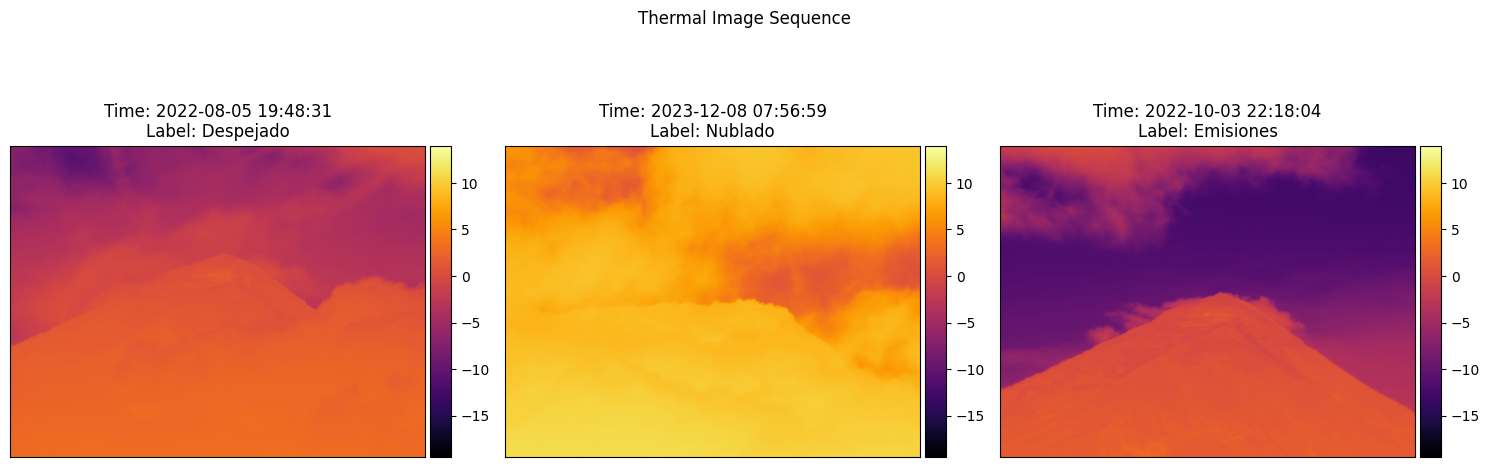

In [46]:
def visualize_thermal_sequence(tensor, timestamps, labels, indices, global_min, global_max, label_mapping):
    """
    Visualize a sequence of thermal images.
    
    :param tensor: 3D numpy array or torch tensor of thermal images
    :param timestamps: List of timestamps for each image
    :param labels: Tensor or list of numeric labels for each image
    :param indices: List of indices to visualize
    :param global_min, global_max: Temperature range for color scaling
    :param label_mapping: Dictionary to map numeric labels back to text
    """
    # Invertir el mapeo de etiquetas para convertir números a texto
    inv_label_mapping = {v: k for k, v in label_mapping.items()}
    
    n_images = len(indices)
    fig, axes = plt.subplots(1, n_images, figsize=(5 * n_images, 5))
    
    for i, idx in enumerate(indices):
        im = axes[i].imshow(tensor[:, :, idx].cpu(), cmap='inferno', 
                            vmin=global_min, vmax=global_max)
        
        # Convertir la etiqueta numérica a texto
        label_text = inv_label_mapping[labels[idx].item()] if isinstance(labels, torch.Tensor) else inv_label_mapping[labels[idx]]
        axes[i].set_title(f'Time: {timestamps[idx]}\nLabel: {label_text}')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
    
    plt.suptitle('Thermal Image Sequence', y=1.05)
    plt.tight_layout()
    plt.show()

# Obtener el rango de temperaturas y estadísticas básicas
global_min = torch.min(corrected_tensor).item()
global_max = torch.max(corrected_tensor).item()
mean_temp = torch.mean(corrected_tensor).item()
std_temp = torch.std(corrected_tensor).item()

# Obtener los timestamps y etiquetas
timestamps = dataset['metadata']['timestamps']
labels_data = prepare_labels(dataset)
numeric_labels = labels_data['numeric_labels']

# Imprimir estadísticas de temperatura
print("Temperature Statistics:")
print(f"Global min: {global_min:.2f}°C")
print(f"Global max: {global_max:.2f}°C")
print(f"Mean temperature: {mean_temp:.2f}°C")
print(f"Standard deviation: {std_temp:.2f}°C")

# Visualizar ejemplos de cada etiqueta
label_mapping = labels_data['label_mapping']
label_examples = {}
for label in label_mapping.values():
    label_indices = [i for i, l in enumerate(numeric_labels) if l.item() == label]
    if label_indices:
        label_examples[label] = label_indices[0]  # Primer ejemplo de cada etiqueta

visualize_thermal_sequence(
    corrected_tensor,
    timestamps,
    numeric_labels,
    list(label_examples.values()),
    global_min,
    global_max,
    label_mapping
)

## Execute Zonal Statistics Tensor

In [47]:
# Crear tensor de estadísticas zonales
print("Creating zonal statistics tensor...")

# Formatear estadísticas zonales para CNN
zonal_tensor_np = format_zonal_stats_for_cnn(dataset)  # Asegura obtener un array de numpy
zonal_tensor = torch.tensor(zonal_tensor_np).float().to(device)  # Convertir a PyTorch y mover al dispositivo
dataset['tensors']['zonal'] = zonal_tensor  # Guardar en el dataset si es necesario

# Imprimir información sobre el tensor zonal
print(f"\nZonal tensor shape: {zonal_tensor.shape}")
print("Features per segment:", ['mean', 'std', 'min', 'max', 'median'])
print("Number of segments:", 9)

Creating zonal statistics tensor...

Zonal tensor shape: torch.Size([1000, 45])
Features per segment: ['mean', 'std', 'min', 'max', 'median']
Number of segments: 9


Zonal Statistics Summary:
Global min: -19.44
Global max: 14.00
Mean value: -5.02
Standard deviation: 7.52

Visualizing zonal statistics for each label...


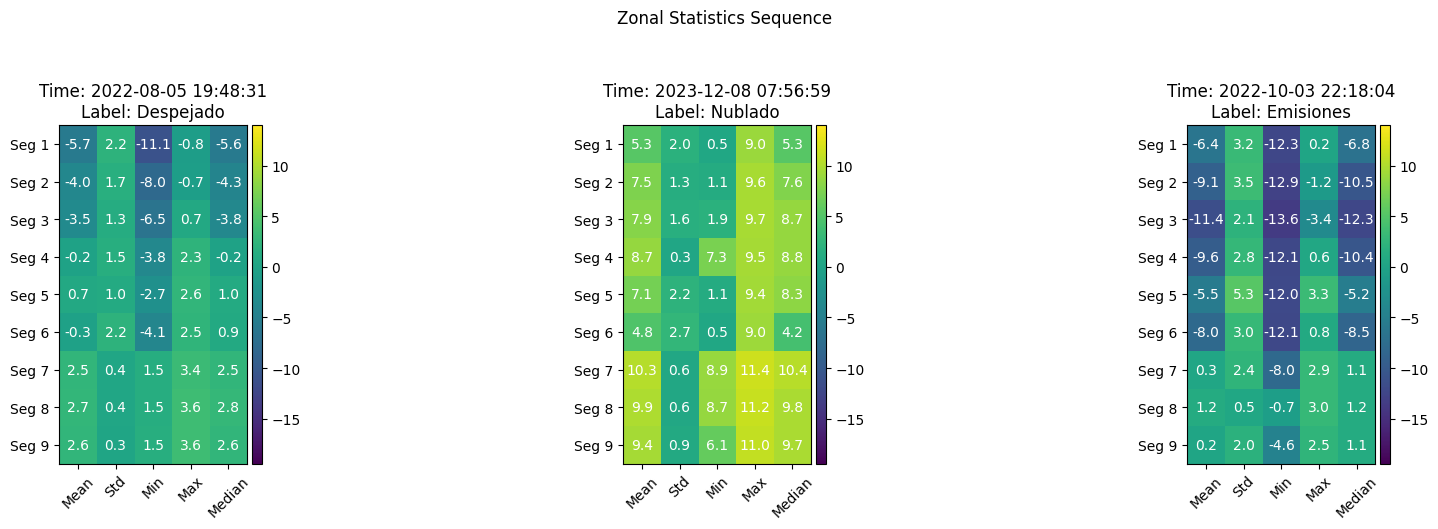

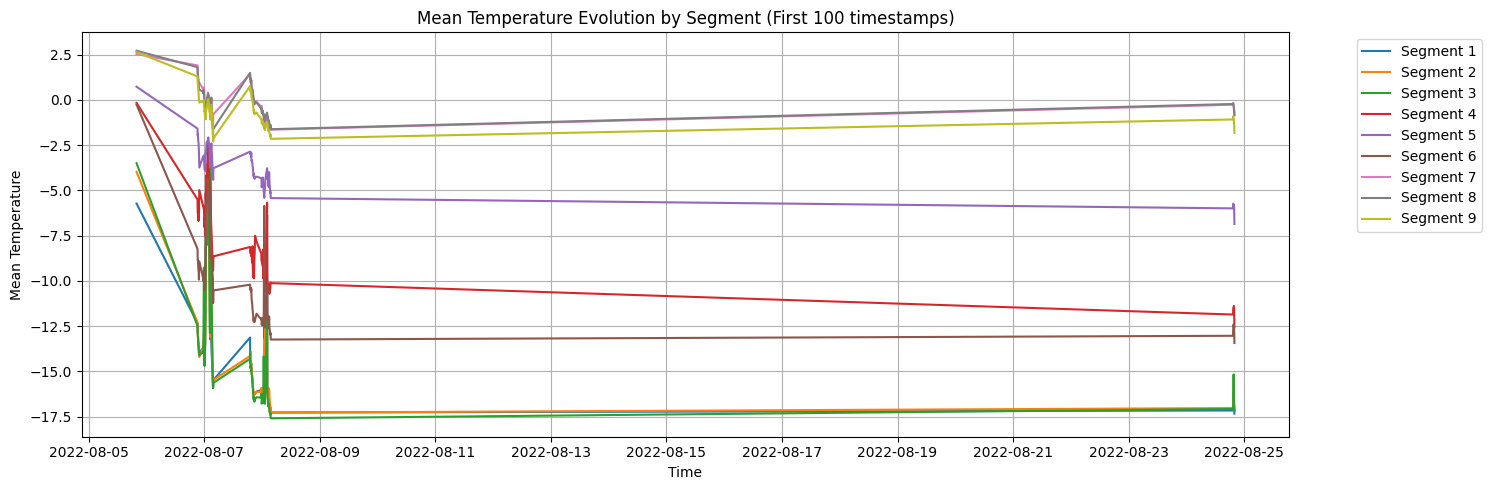

In [48]:
def visualize_zonal_sequence(zonal_tensor, timestamps, labels, indices, label_mapping):
    """
    Visualize a sequence of zonal statistics.
    
    :param zonal_tensor: 2D torch tensor (n_images, 45) of zonal statistics
    :param timestamps: List of timestamps for each image
    :param labels: Tensor or list of numeric labels for each image
    :param indices: List of indices to visualize
    :param label_mapping: Dictionary to map numeric labels back to text
    """
    # Invertir el mapeo de etiquetas para convertir números a texto
    inv_label_mapping = {v: k for k, v in label_mapping.items()}
    
    n_images = len(indices)
    fig, axes = plt.subplots(1, n_images, figsize=(6 * n_images, 5))
    
    # Nombres de estadísticas para etiquetar
    stat_names = ['Mean', 'Std', 'Min', 'Max', 'Median']
    
    # Obtener min y max globales para la escala del mapa de color
    global_min = torch.min(zonal_tensor).item()
    global_max = torch.max(zonal_tensor).item()
    
    for i, idx in enumerate(indices):
        # Reorganizar estadísticas para esta imagen (9 segmentos, 5 estadísticas)
        stats = zonal_tensor[idx].reshape(9, 5).cpu().numpy()
        
        # Crear mapa de calor
        im = axes[i].imshow(stats, cmap='viridis', 
                            vmin=global_min, vmax=global_max)
        
        # Convertir la etiqueta numérica a texto
        label_text = inv_label_mapping[labels[idx].item()] if isinstance(labels, torch.Tensor) else inv_label_mapping[labels[idx]]
        axes[i].set_title(f'Time: {timestamps[idx]}\nLabel: {label_text}')
        
        # Agregar etiquetas
        axes[i].set_xticks(np.arange(5))
        axes[i].set_xticklabels(stat_names, rotation=45)
        axes[i].set_yticks(np.arange(9))
        axes[i].set_yticklabels([f'Seg {j+1}' for j in range(9)])
        
        # Agregar barra de color
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        
        # Agregar anotaciones de texto
        for y in range(9):
            for x in range(5):
                text = axes[i].text(x, y, f'{stats[y, x]:.1f}',
                                    ha="center", va="center", 
                                    color="white" if stats[y, x] < (global_max - global_min) / 2 
                                    else "black")
    
    plt.suptitle('Zonal Statistics Sequence', y=1.05)
    plt.tight_layout()
    plt.show()

# Obtener estadísticas básicas para el tensor zonal
global_min = torch.min(zonal_tensor).item()
global_max = torch.max(zonal_tensor).item()
mean_val = torch.mean(zonal_tensor).item()
std_val = torch.std(zonal_tensor).item()

print("Zonal Statistics Summary:")
print(f"Global min: {global_min:.2f}")
print(f"Global max: {global_max:.2f}")
print(f"Mean value: {mean_val:.2f}")
print(f"Standard deviation: {std_val:.2f}")

# Obtener ejemplos de cada etiqueta
print("\nVisualizing zonal statistics for each label...")
label_mapping = labels_data['label_mapping']
label_examples = {}
for label in label_mapping.values():
    label_indices = [i for i, l in enumerate(numeric_labels) if l.item() == label]
    if label_indices:
        label_examples[label] = label_indices[0]  # Tomar el primer ejemplo de cada etiqueta

# Visualizar la secuencia zonal
visualize_zonal_sequence(
    zonal_tensor,
    timestamps,
    numeric_labels,
    list(label_examples.values()),
    label_mapping
)

# Graficar la evolución temporal de una estadística seleccionada
plt.figure(figsize=(15, 5))
for segment in range(9):
    # Graficar la temperatura media para cada segmento (primeros 100 timestamps)
    plt.plot(timestamps[:100], zonal_tensor[:100, segment * 5].cpu().numpy(), 
             label=f'Segment {segment+1}')
plt.title('Mean Temperature Evolution by Segment (First 100 timestamps)')
plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Execute Edge Detection Tensor

In [51]:
# Crear tensor de detección de bordes Canny
print("Creating edge detection tensor...")

# Llamar a la función que genera los tensores de detección de bordes
edge_detection_data = create_edge_detection_tensors(corrected_tensor)

# Convertir los resultados en tensores de PyTorch y moverlos al dispositivo
edge_tensor = torch.tensor(edge_detection_data['edge_tensor']).float().to(device)
edge_features = torch.tensor(edge_detection_data['edge_features']).float().to(device)
segment_features = torch.tensor(edge_detection_data['segment_features']).float().to(device)

# Almacenar los tensores en el dataset si es necesario
dataset['tensors']['edge'] = edge_tensor
dataset['tensors']['edge_features'] = edge_features
dataset['tensors']['segment_features'] = segment_features

# Imprimir información sobre los tensores
print(f"\nEdge tensor shape: {edge_tensor.shape}")
print(f"Edge features shape: {edge_features.shape}")
print(f"Segment features shape: {segment_features.shape}")

Creating edge detection tensor...

Edge tensor shape: torch.Size([480, 640, 1000])
Edge features shape: torch.Size([1000, 3])
Segment features shape: torch.Size([1000, 9, 3])



Edge Detection Statistics:
Average edge density: 0.0036
Average total edges: 1094.11
Average non-zero ratio: 0.0036

Visualizing edge detection examples for each label...


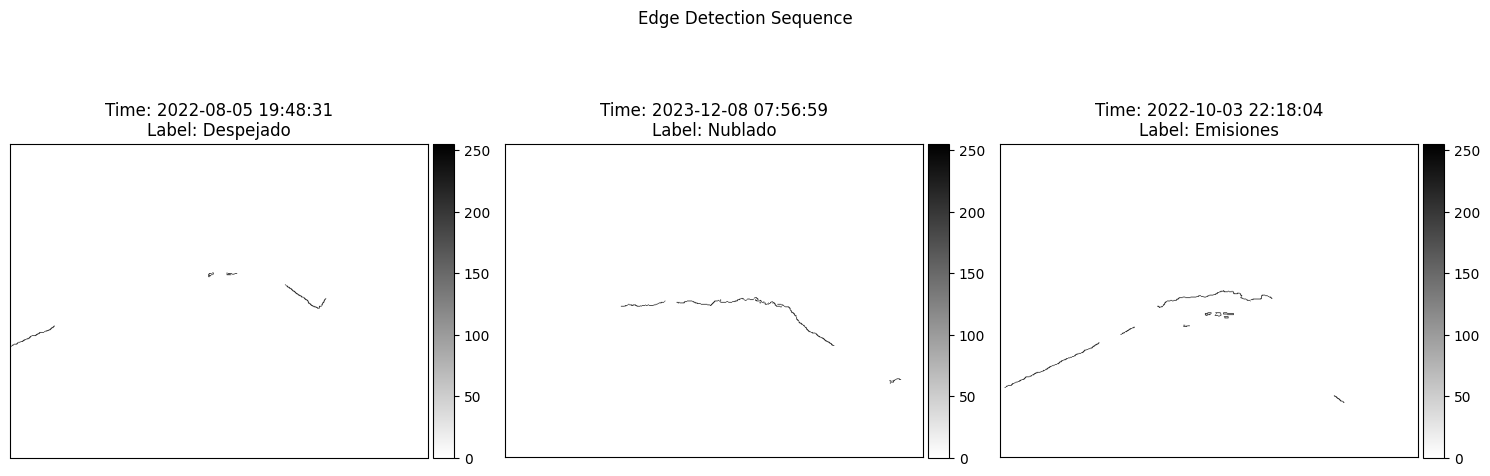

In [52]:
def visualize_edge_sequence(tensor, timestamps, labels, indices, label_mapping):
    """
    Visualize a sequence of edge detection images.
    
    :param tensor: 3D torch tensor of edge detection images
    :param timestamps: List of timestamps for each image
    :param labels: Tensor or list of numeric labels for each image
    :param indices: List of indices to visualize
    :param label_mapping: Dictionary to map numeric labels back to text
    """
    # Invertir el mapeo de etiquetas para convertir números a texto
    inv_label_mapping = {v: k for k, v in label_mapping.items()}
    
    n_images = len(indices)
    fig, axes = plt.subplots(1, n_images, figsize=(5 * n_images, 5))
    
    for i, idx in enumerate(indices):
        # Convertir tensor a numpy para visualización y asegurarse de que está en la CPU
        edge_image = tensor[:, :, idx].cpu().numpy()
        
        # Para las imágenes de bordes, usamos un mapa de color binario
        im = axes[i].imshow(edge_image, cmap='binary', vmin=0, vmax=255)
        
        # Convertir la etiqueta numérica a texto
        label_text = inv_label_mapping[labels[idx].item()] if isinstance(labels, torch.Tensor) else inv_label_mapping[labels[idx]]
        axes[i].set_title(f'Time: {timestamps[idx]}\nLabel: {label_text}')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
    
    plt.suptitle('Edge Detection Sequence', y=1.05)
    plt.tight_layout()
    plt.show()

# Calcular estadísticas de detección de bordes
edge_density = torch.mean(edge_features[:, 0]).item()
total_edges = torch.mean(edge_features[:, 1]).item()
non_zero_ratio = torch.mean(edge_features[:, 2]).item()

print("\nEdge Detection Statistics:")
print(f"Average edge density: {edge_density:.4f}")
print(f"Average total edges: {total_edges:.2f}")
print(f"Average non-zero ratio: {non_zero_ratio:.4f}")

# Visualizar ejemplos de cada etiqueta
print("\nVisualizing edge detection examples for each label...")
label_mapping = labels_data['label_mapping']
label_examples = {}
for label in label_mapping.values():
    label_indices = [i for i, l in enumerate(numeric_labels) if l.item() == label]
    if label_indices:
        label_examples[label] = label_indices[0]  # Tomar el primer ejemplo de cada etiqueta

# Visualizar secuencia de detección de bordes
visualize_edge_sequence(
    edge_tensor,
    timestamps,
    numeric_labels,
    list(label_examples.values()),
    label_mapping
)

## Execute Threshold Tensors

In [91]:
# Crear tensores de umbral de temperatura
print("Creating temperature threshold tensors...")
threshold_data = create_thermal_threshold_tensor(corrected_tensor)

# Opcional: Almacenar los tensores de umbral en el dataset si es necesario
for name, tensor in threshold_data['tensors'].items():
    dataset['tensors'][f'threshold_{name}'] = tensor

# Imprimir información sobre los tensores de umbral
for name, tensor in threshold_data['tensors'].items():
    print(f"\nThreshold tensor '{name}' shape: {tensor.shape}")


Creating temperature threshold tensors...

Threshold tensor 'low' shape: torch.Size([480, 640, 1000])

Threshold tensor 'medium' shape: torch.Size([480, 640, 1000])

Threshold tensor 'high' shape: torch.Size([480, 640, 1000])

Threshold tensor 'very_high' shape: torch.Size([480, 640, 1000])


In [92]:
def visualize_thermal_threshold_comparison(thermal_tensor, timestamps, labels, indices, label_mapping):
    """
    Visualize thermal images and their thresholded versions for all thresholds.
    
    :param thermal_tensor: Original thermal image tensor (PyTorch tensor)
    :param timestamps: List of timestamps for each image
    :param labels: List or tensor of numeric labels for each image
    :param indices: List of indices to visualize
    :param label_mapping: Dictionary to map numeric labels back to text
    """
    # Invertir el mapeo de etiquetas para convertir números a texto
    inv_label_mapping = {v: k for k, v in label_mapping.items()}
    
    n_images = len(indices)
    fig, axes = plt.subplots(5, n_images, figsize=(5 * n_images, 25))
    
    # Obtener el rango de temperaturas para un colormap consistente
    vmin, vmax = thermal_tensor.min().item(), thermal_tensor.max().item()
    
    # Crear los tensores de umbral
    threshold_data = create_thermal_threshold_tensor(thermal_tensor)
    
    for i, idx in enumerate(indices):
        # Convertir imagen térmica original a numpy para visualización y asegurar que esté en la CPU
        thermal_image = thermal_tensor[:, :, idx].cpu().numpy()
        
        # Imagen térmica original
        im1 = axes[0, i].imshow(thermal_image, cmap='inferno', vmin=vmin, vmax=vmax)
        # Convertir la etiqueta numérica a texto
        label_text = inv_label_mapping[labels[idx].item()] if isinstance(labels, torch.Tensor) else inv_label_mapping[labels[idx]]
        axes[0, i].set_title(f'Time: {timestamps[idx]}\nLabel: {label_text}')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        
        divider = make_axes_locatable(axes[0, i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im1, cax=cax, label='Temperature (°C)')
        
        # Imágenes con umbrales
        for j, (name, threshold) in enumerate(threshold_data['thresholds'].items(), 1):
            # Convertir la imagen de umbral a numpy y asegurarse de que esté en la CPU
            threshold_image = threshold_data['tensors'][name][:, :, idx].cpu().numpy()
            axes[j, i].imshow(threshold_image, cmap='binary', vmin=0, vmax=255)
            axes[j, i].set_title(f'Threshold: T > {threshold}°C')
            axes[j, i].set_xticks([])
            axes[j, i].set_yticks([])
    
    plt.tight_layout()
    plt.show()

# Ejecutar el análisis de umbrales
print("Creating and visualizing threshold analysis...")

# Obtener ejemplos de imágenes para cada etiqueta
label_mapping = labels_data['label_mapping']
label_examples = {}
for label in label_mapping.values():
    label_indices = [i for i, l in enumerate(numeric_labels) if l.item() == label]
    if label_indices:
        label_examples[label] = label_indices[0]

# Crear la visualización
visualize_thermal_threshold_comparison(
    corrected_tensor,
    timestamps,
    numeric_labels,
    list(label_examples.values()),
    label_mapping
)

Creating and visualizing threshold analysis...


## Execute Temporal Feautures Tensor

In [62]:
# Crear tensor temporal
print("Creating temporal tensor...")
temporal_data = create_temporal_tensor(timestamps, corrected_tensor.shape).to(device)

# Agregar el tensor temporal al dataset
dataset['tensors']['temporal'] = temporal_data
print(f"Temporal tensor shape: {temporal_data.shape}")

Creating temporal tensor...
Temporal tensor shape: torch.Size([480, 640, 1000, 6])


## Multi-branch Model

In [97]:
class MultiBranchModel(nn.Module):
    def __init__(self, n_classes):
        super(MultiBranchModel, self).__init__()
        
        # Rama para el tensor corregido (entrada de imágenes)
        self.corrected_branch = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        
        # Rama para el tensor zonal
        #self.zonal_branch = nn.Sequential(
        #    nn.Linear(45, 64),  # 45 es el número de características en zonal_tensor
        #    nn.ReLU(),
        #    nn.Linear(64, 32),
        #    nn.ReLU()
        #)
        
        # Rama para el tensor de detección de bordes
        self.edge_branch = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
               
        # Rama para el tensor de umbrales
        self.threshold_branch = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        
        # Rama para el tensor temporal
        self.temporal_branch = nn.Sequential(
            nn.Linear(6, 16),  # 6 es el número de características en temporal_tensor
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        
        # Capa final para combinar todas las ramas
        self.fc = nn.Sequential(
            nn.Linear(32*3 + 32 + 8, 128),  # Ajustar tamaño según las salidas de las ramas
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)  # n_classes es el número de clases de salida
        )

    def forward(self, corrected, edge, threshold, temporal):
        # Procesar cada rama
        x1 = self.corrected_branch(corrected)
        #x2 = self.zonal_branch(zonal)
        x2 = self.edge_branch(edge)
        x3 = self.threshold_branch(threshold)
        x4 = self.temporal_branch(temporal)
        
        # Concatenar las salidas
        x = torch.cat((x1, x2, x3, x4), dim=1)
        
        # Pasar por la capa final
        x = self.fc(x)
        return x

# Inicializar el modelo, la función de pérdida y el optimizador
n_classes = len(labels_data['label_mapping'])
model = MultiBranchModel(n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [113]:
corrected_tensor = torch.from_numpy(dataset['tensors']['corrected']).permute(2, 0, 1).unsqueeze(1)  # (1000, 1, 480, 640)
edge_tensor = torch.from_numpy(dataset['tensors']['edge']).permute(2, 0, 1).unsqueeze(1)            # (1000, 1, 480, 640)
threshold_tensor = torch.from_numpy(dataset['tensors']['threshold_low']).permute(2, 0, 1).unsqueeze(1)  # (1000, 1, 480, 640)
temporal_tensor = torch.from_numpy(dataset['tensors']['temporal']).permute(2, 3, 0, 1)  # (1000, 6, 480, 640)
#zonal_tensor = torch.from_numpy(dataset['tensors']['zonal'])  # (1000, 45)
labels_tensor = torch.from_numpy(labels_data['numeric_labels'])

IndexError: too many indices for tensor of dimension 4

In [103]:
# Crear el dataset usando los tensores reorganizados
dataset = TensorDataset(
    corrected_tensor,
    edge_tensor,
    temporal_tensor,
    threshold_tensor,
    labels_tensor
)

# Crear un DataLoader
batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)